In [1]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


#set a random seed for reproducibility
np.random.seed(1)

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

1. Who are the different types of customers?
>- By applying K-means clustering on spending across different product categories, I want to identify distinct segments of customers based on their purchasing patterns.<br>

In [2]:
# load the wholesale customers data as pandas dataframe
# display a sample of 10 rows randomly selected for visual inspection
df = pd.read_csv('Wholesale customers data.csv')
df.sample(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
283,1,3,25767,3613,2013,10303,314,1384
369,1,3,6211,337,683,1089,41,296
207,2,1,2541,4737,6089,2946,5316,120
300,2,2,16448,6243,6360,824,2662,2005
429,1,3,8607,1750,3580,47,84,2501
422,1,3,26400,1377,4172,830,948,1218
47,2,3,44466,54259,55571,7782,24171,6465
350,1,3,3521,1099,1997,1796,173,995
232,1,1,25962,1780,3838,638,284,834
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
# for ease of typing and consistency, change the column names to all lowercase - just my preference
df.columns = df.columns.str.lower()
df.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


The categorical variables are nominal (without a natural order), directly including them in K-means clustering for this problem can lead to misleading results.<br>
I will exclude the categorical features because it does not have any significant meaning in this context - analysing spending patterns for the different product categories.

In [4]:
# slice the dataset to remove the categorical features - slicing is easy here as the features appear in the first two columns
products = df.iloc[:, 2:]
products.head()

,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


#### 1. Data Exploration & Identification of Relevant Attributes
- Explore the data for tidiness and quality issues that might need fixing.
- The following section checks for missing values, duplicate values, outliers, feature distribution

In [5]:
# check for duplicate values
duplicates = products.duplicated().sum()
print('The Dataset has {} duplicates'.format(duplicates))

The Dataset has 0 duplicates


In [6]:
# check for missing values
products.isnull().sum()

fresh               0
milk                0
grocery             0
frozen              0
detergents_paper    0
delicassen          0
dtype: int64

In [7]:
# statistical description of the numerical columns in the dataset
products.describe().T

,count,mean,std,min,25%,50%,75%,max
fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
detergents_paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


Mean (Average Spending):

- **Fresh Products:** Mean spending is around 12,000, which is the highest among all categories. This suggests that on average, customers spend the most on fresh products.<br>
- **Milk:** Average spending is approximately 5,800, which is moderate compared to other categories.<br>
- **Grocery:** The mean of around 7,950 indicates a significant portion of spending in this category.<br>
- **Frozen:** The average spending here is around 3,070, suggesting it's a less dominant category compared to the first three in terms of spending.<br>
- **Detergents and Paper:** The mean of about 2,880 indicates a relatively lower average expenditure in this category.<br>
- **Delicatessen:** The lowest mean spending of around 1,525 suggests this is the least purchased category on average.<br>


Standard Deviation (Variability in Spending):

- The standard deviation values are quite high across all categories, especially in relation to their means. This suggests a large variability in customer spending within each category.<br>
- Fresh Products, Milk, and Grocery have particularly high standard deviations, indicating that spending in these categories varies widely among different customers.<br>
- The high standard deviations also imply that the data is spread out over a wide range of values, and there may be significant outliers or differences in purchasing behavior.

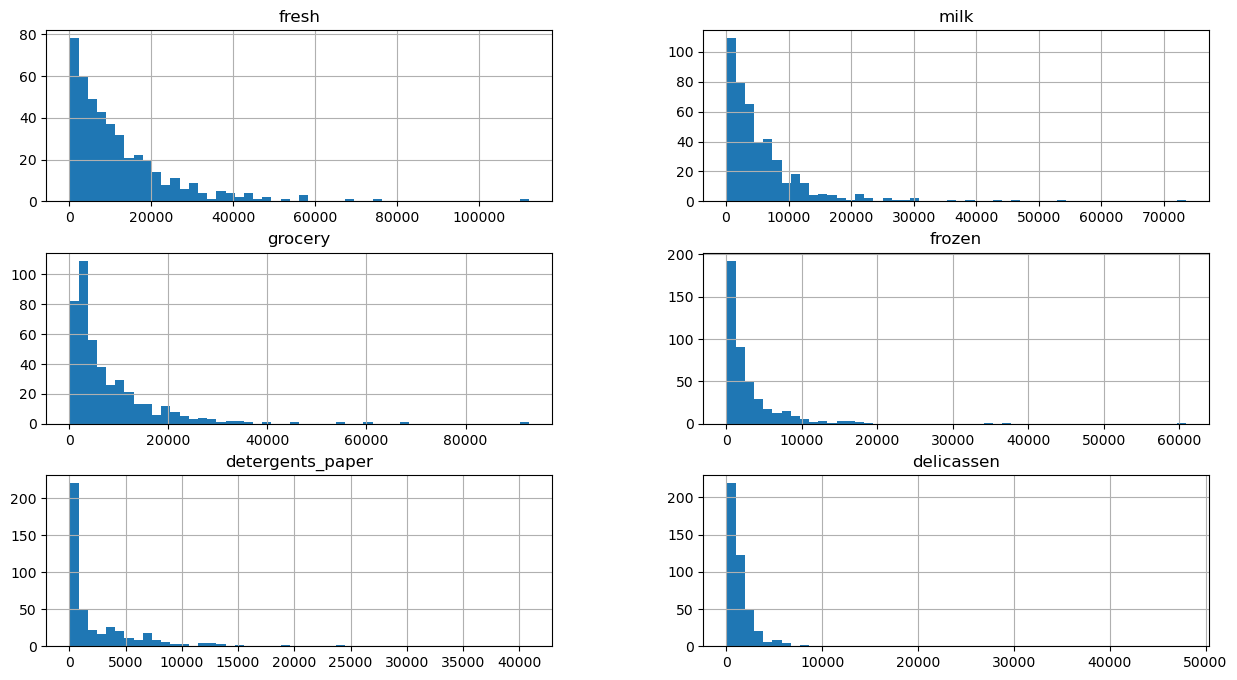

In [8]:
# histogram to show the distribution of the dataset
products.hist(bins=50, figsize=(15, 8))
plt.show()

- All six category of product has a long tail distribution (right skewed) with bulk of the annual spending below 10,000 monetary untis.<br>A closer examination shows there are outliers in the dataset. I will verify this using boxplot.

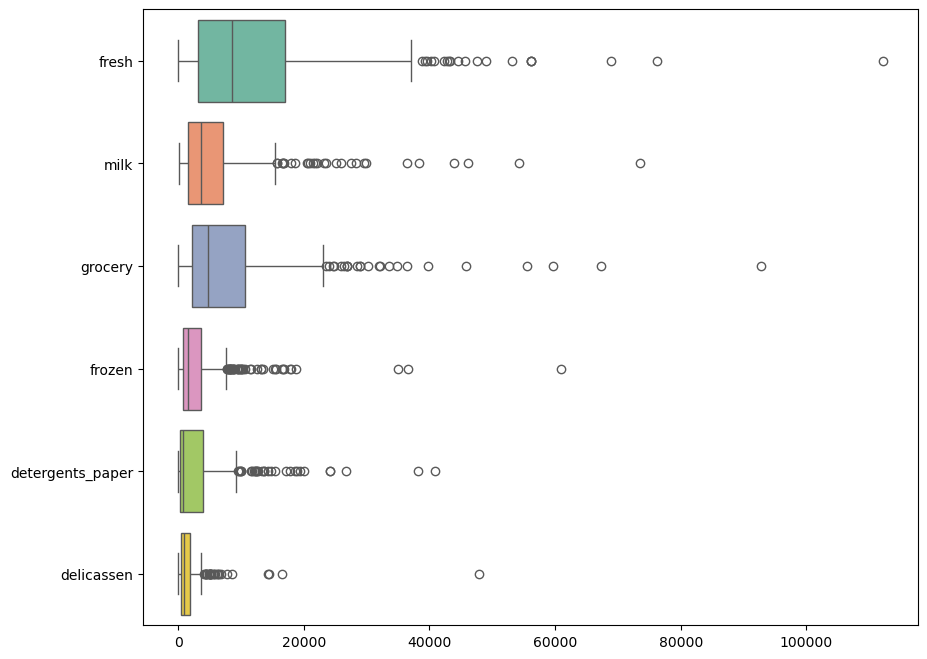

In [9]:
# boxplot to verify if the dataset contains outliers
plt.figure(figsize = (10, 8))
sns.boxplot(products, orient = 'h', palette = "Set2")
plt.show()

- The boxplot shows that there are outliers in the dataset. These outliers can skew this mean significantly, leading to suboptimal centroid<br> placement (K-means algorithm). Removing the outliers will help to ensure that the centroids are more representative of the majority of the data points.

In [10]:
# Quartiles
Q1 = np.percentile(products, 25, axis=0)
Q3 = np.percentile(products, 75, axis=0)
IQR = Q3 - Q1
threshold = 1.5

# Find the indices of outliers
outliers = (products < Q1 - threshold * IQR) | (products > Q3 + threshold * IQR)

# Remove rows containing outliers
df_no_outliers = products[~outliers.any(axis=1)]

### 2. Feature Scaling
- Standardizing the range of the variables (transforming the data so that all features fits within a specific scale)
- The purpose is to ensure that all features contribute equally to the model and to avoid the domination of features with larger values

In [11]:
# feature scaling using the StandardScalar method
scalar = StandardScaler()
scaled_data = scalar.fit_transform(df_no_outliers)
normalized_df = pd.DataFrame(scaled_data, columns = df_no_outliers.columns)
normalized_df.head()

,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,0.383041,1.652898,0.334978,-0.967004,0.305053,0.390465
1,-0.305588,1.698756,0.733878,-0.059255,0.569139,0.922591
2,0.456174,-0.866283,-0.328862,2.662821,-0.619462,0.937169
3,-0.016491,1.236906,-0.148989,-0.701951,-0.069958,0.527749
4,0.316411,-0.269838,0.218508,-0.811022,0.503864,-0.572949


### 3. K-means Clustering

  File "c:\Users\Percy Chukwudi\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


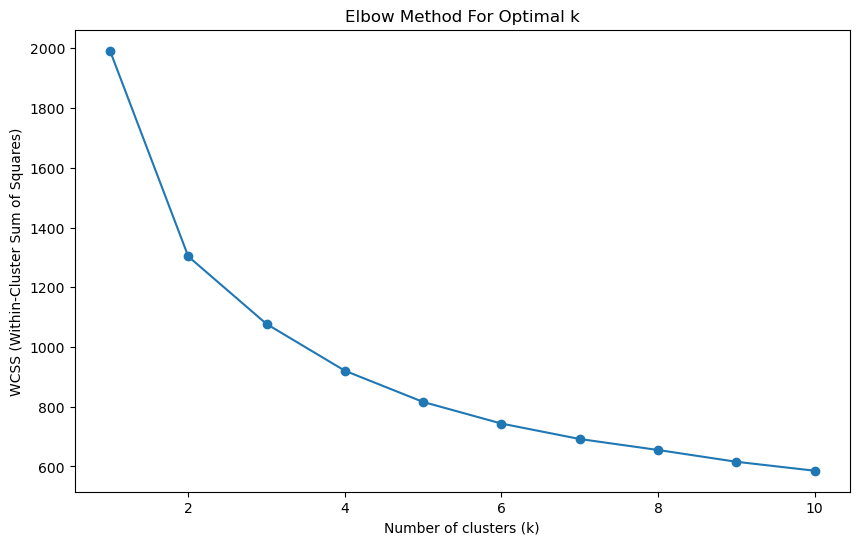

In [12]:
# Calculate within-cluster sum of squares (WCSS) for different values of k
wcss = []
K = range(1, 11) 
for k in K:
    km = KMeans(n_clusters = k, random_state = 42)
    km = km.fit(normalized_df)
    wcss.append(km.inertia_)

# Plotting the Elbow Plot
plt.figure(figsize = (10, 6))
plt.plot(K, wcss, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal k')
plt.show()

From the Elbow Plot, the optimal number of K = 4. Beyond this point, the slope of the curve does not show any significant change (steepness)

In [13]:
# Create a KMeans instance with k clusters
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans = kmeans.fit(normalized_df)
cluster_assignments = kmeans.labels_
df_no_outliers['cluster'] = cluster_assignments

In [14]:
# Print the centroids of each cluster
centroids = kmeans.cluster_centers_
centroids

array([[-0.32449512, -0.46124056, -0.50304958, -0.51381161, -0.47456955,
        -0.46757151],
       [-0.5313599 ,  1.21207591,  1.39007286, -0.34838081,  1.49949024,
         0.38610413],
       [ 0.2399374 , -0.57843878, -0.60480566,  1.43511089, -0.57050084,
        -0.19145375],
       [ 1.67057925,  0.27528931,  0.129655  , -0.05408889, -0.22715174,
         1.17630184]])

In [15]:
# convert the array of centroids into pandas DataFrame
centroid_df = pd.DataFrame(centroids, columns=[
                           'fresh', 'milk', 'grocery', 'frozen', 'detergents_paper', 'delicassen'])

centroid_df

,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,-0.324495,-0.461241,-0.503050,-0.513812,-0.474570,-0.467572
1,-0.531360,1.212076,1.390073,-0.348381,1.499490,0.386104
2,0.239937,-0.578439,-0.604806,1.435111,-0.570501,-0.191454
3,1.670579,0.275289,0.129655,-0.054089,-0.227152,1.176302


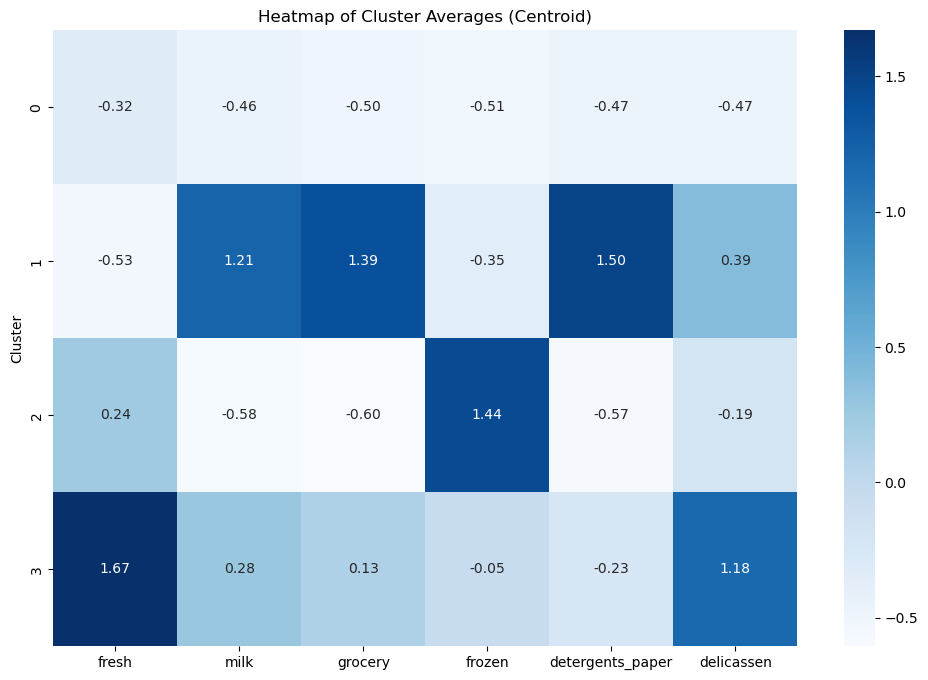

In [16]:
# plot a heat map of the cluster average
plt.figure(figsize = (12, 8))
sns.heatmap(centroid_df, annot = True, cmap = "Blues", fmt = '.2f')
plt.title("Heatmap of Cluster Averages (Centroid)")
plt.ylabel('Cluster')
plt.show()

### 4. Analysis and Interpretation

> **Cluster 1 (Lower Spending Across All Categories): Conservative Shoppers**

- These customers have below-average spending across all categories, indicating they might be more budget-conscious or purchase less frequently.

> **Cluster 2 (High Spending on Milk, Grocery, and Detergents_Paper): Household Essentials Focused**

- Above-average spending in specific categories like Milk, Grocery, and Detergents_Paper suggests this category could be large households that stock up on daily essentials in bulk.

> **Cluster 3 (Higher Spending on Frozen, Lower on Others): Convenience Shoppers**

This segment's preference for Frozen items, coupled with lower spending in other categories, suggests a focus on convenience and perhaps a lesser emphasis on fresh produce.

> **Cluster 4 (High Spending on Fresh and Delicatessen): Delicacy Lovers**

- This group's significant spending on Fresh and Delicatessen items indicates a preference for high-quality, fresh food. They could be either gourmet home cooks or businesses that prioritize premium, fresh ingredients.<br>

> These names aim to capture the essence of each customer group's spending habits, which can be a valuable insight for targeted marketing, inventory management, and personalized customer engagement strategies.




